# Behavioral systems: <q>Model-free</q> simulations

## DAIS presentation 
## Nathan Lawrence
### March 2022

In [28]:
# You ~may~ need to be running Julia 1.7 for this notebook to work properly
# Uncomment if this is your first time using this notebook:
using Pkg
# Pkg.add(["ControlSystems","LinearAlgebra","Statistics","Plots","LaTeXStrings","RollingFunctions"]);

# moving all the helper functions to `nbtools.jl`
include("../src/nbtools.jl")

# Behavioral systems

Let $P$ denote a linear time invariant system (LTI):

\begin{align}
	x_{t+1} &= A x_{t} + B u_{t},\quad x_0 = \bar{x} \\
	y_{t} &= C x_{t} + D u_{t}
\end{align}

* Now let's take a sequence of input-output data $u_0, y_0, u_1, y_1, \ldots, u_{N-1}, y_{N-1}$
* Next, slice the sequence into several "windows" of length $L\leq N$
\begin{align}
    &
    \begin{bmatrix}
        u_0 & u_1 & \ldots & u_{L-1} \\
        y_0 & y_1 & \ldots & y_{L-1}
    \end{bmatrix} \\
    &
    \begin{bmatrix}
        u_1 & u_2 & \ldots & u_{L} \\
        y_1 & y_2 & \ldots & y_{L}
    \end{bmatrix} \\
    & \vdots \\
    &
    \begin{bmatrix}
        u_{N-L} & u_{N-L+1} & \ldots & u_{N-1} \\
        y_{N-L} & y_{N-L+1} & \ldots & y_{N-1}
    \end{bmatrix} \\
\end{align}

> How can we span the whole space of possible windows of length $L$?

# Spanning trajectories

Intuitively, we collect these "windows" into a matrix and demand them them to have full rank.

Formally, given a sequence of data $\{ u_{t} \}_{t = 0}^{N-1} \subset \mathbb{R}^m$ of length $N$, the **Hankel matrix** of order $L$ is given by:

$$
H_{L}(u) =
\begin{bmatrix}
	u_{0} & u_{1} & \ldots & u_{N-L} \\
	u_{1} & u_{2} & \ldots & u_{N-L+1} \\
	\vdots & \vdots & \ddots & \vdots \\
	u_{L-1} & u_{L} & \ldots & u_{N-1}
\end{bmatrix}
$$

Moreover, if $\text{rank}(H_{L}(u) = mL$ then $u$ is said to be **persistently exciting** of order $L$.

Theorem:

> Let $\{ u_{t}, y_{t} \}_{t = 0}^{N-1}$ be a trajectory of an LTI system $(A, B, C, D)$ where $u$ is persistently exciting of order $L+n$. Then $\{ \bar{u}_{t}, \bar{y}_{t} \}_{t = 0}^{L-1}$ is a trajectory of $(A, B, C, D)$ **if and only if** there exists $\alpha \in \mathbb{R}^{N-L+1}$ such that
$$
\begin{bmatrix}
	H_L(u) \\
	H_L(y) 
\end{bmatrix}
\alpha =
\begin{bmatrix}
\bar{u} \\
\bar{y}	
\end{bmatrix}
$$



* We only need an input-output trajectory to characterize **all** trajectories of an unknown LTI system
* Only an **upper bound** of the order of the system is needed
* The theorem implicitly tells us a data requirement (by the rank condition):
$$
N - (L - n) + 1 \geq m(L+n) \implies N \geq (m+1)(L+n) - 1
$$


# Let's implement this!

* `excite()` for generating a persistenly exciting signal.
* `Hankel()` for constructing a Hankel matrix from a provided signal.

In [29]:
# excite() : persistently exciting input data (simple) -- moved to nbtools.jl

In [30]:
# Hankel(): Construct Hankel matrix


* We define an LTI system:
$$
P_c(s) = \frac{1}{s^2 + 2s+ 1}
$$
* We discretize in time, giving us the "true" system of interest $P$.
* We view $P$ as **unknown**.

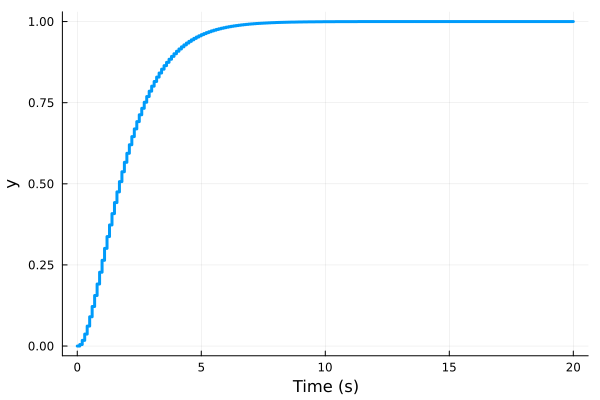

In [31]:
s = tf("s")
P_c = 1/(s^2 + 2s + 1)
Ts = 0.1
P = c2d(P_c,  Ts)

plot(step(P), lw=3)

## Next we get a Hankel representation of $P$

* The order of $P$ is 2, but we don't need to be that precise.
* Let's give an upper bound of $\nu = 5$ for demonstration purposes.
* The goal then is as follows:
    **Generate all the trajectories of system $P$ of length $L$**


## <q>Training</q> data

In [32]:
ν = 5
L = 20

# Probe the 'true' system
u = excite(ν+L)
y, t, x,  = lsim(P, u')
H_u = Hankel(u, L)
H_y = Hankel(vec(y), L)
;

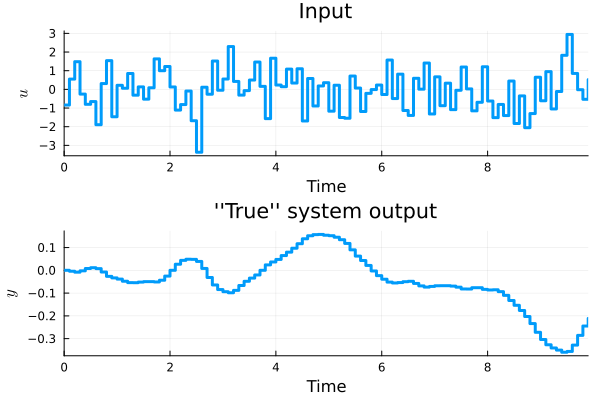

In [33]:
plt = plot( 
    xaxis  = ("Time", ),
    xlims = (0, t[end]),
    legend = false,
    layout = (2,1),
)
plot!(plt[1], t, u, title = "Input", ylabel = L"u", linetype=:step, lw=3)
plot!(plt[2], t, y', title = "''True'' system output", ylabel = L"y", linetype=:step, lw=3)

## Open loop response with Hankel matrix

* We start with an initial trajectory $\{ \bar{u}_t, \bar{y}_t \}_{t = 0}^{\nu-1}$ of input-output data.
* We provide a vector of $L$ inputs $\{ \bar{u}_t \}_{t=0}^{L-1}$.
* Goal is to **determine the reminaing outputs** $\{ \bar{y}_t \}_{t = \nu}^{L-1}$.

This is achieved as follows:

* Solve the system of equations for $\alpha$:
$$
\begin{bmatrix}
H_L(u)\\
H_{\nu}(y)
\end{bmatrix}
\alpha
= \begin{bmatrix}
\bar{u}\\
\bar{y}_{0}^{\nu-1}
\end{bmatrix}
$$
* Then $\bar{y} = H_L(y)\alpha$ is the completed trajectory.

In [34]:
## Initialize our trajectory and input data
ū = [zeros(ν); sin.(0:L-1-ν)]
y_init = zeros(ν)

## Truncate "training" data slighly so that the system of equations has the right dimension
H_y_nu = Hankel(vec(y)[1:length(y) - L + ν], ν)

## Solve for α and evaluate ȳ
α = [H_u; H_y_nu] \ [ū; y_init]
ȳ = H_y*α

## Get groundtruth
y, t, x, = lsim(P, ū')
y_true = vec(y)
;

In [35]:
# complete_trajectory() : we can turn the above process into a function for ease

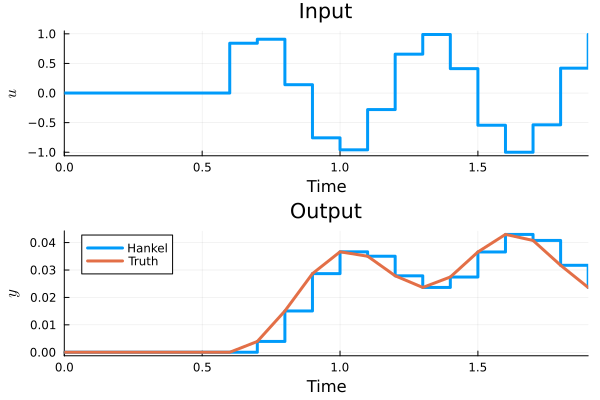

In [36]:
plt = plot( 
    xaxis  = ("Time", ),
    xlims = (0, t[end]),
    layout = (2,1),
)
plot!(plt[1], t, ū, title = "Input", ylabel = L"u", linetype=:step, legend=false, lw=3)
plot!(plt[2], t, ȳ, title = "Output", ylabel = L"y", linetype=:step, label="Hankel", lw=3)
plot!(plt[2], t, y_true, label="Truth", legend=:topleft, lw=3)

## Weaving together trajectories

* In the previous figure we started the trajectory from zero, which **implicitly** intialized the underlying state to zero as well.
* We next show how to **"weave"** together trajectories.
* The only requirement is that $L \geq n$, so that way these trajectories have **overlapping** internal state.
* This process can be repeated **any** number of times, generating arbitrarily long trajectories.
* In the next experiment we intitialize the trajectory with the last $\nu$ data samples $\{ \bar{u}_t, \bar{y}_t \}_{t = L-\nu}^{L-1}$.

In [37]:
ū_cont = [ū[end-ν+1:end]; -0.1*ones(L-ν)]
y_init_cont = ȳ[end-ν+1:end]
;

In [38]:
## Solve for α and evaluate ȳ
α = [H_u; H_y_nu] \ [ū_cont; y_init_cont]
ȳ_cont = H_y*α

## Get groundtruth
input = [ū; ū_cont[ν+1:end]]
y, t_cont, x_cont, = lsim(P, input')
y_true_cont = vec(y)
;

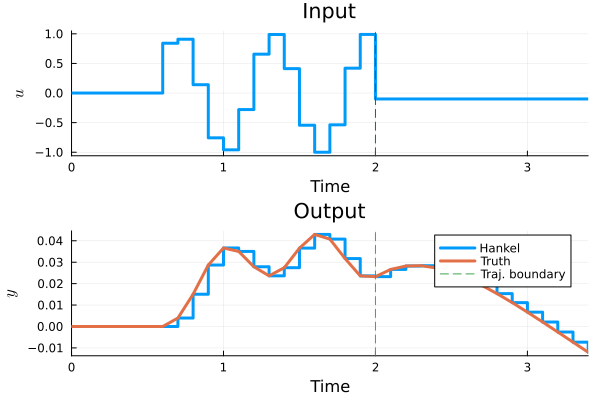

In [39]:
plt = plot( 
    xaxis  = ("Time", ),
    xlims = (0, t_cont[end]),
    layout = (2,1),
)
plot!(plt[1], t_cont, [ū; ū_cont[ν+1:end]], title = "Input", ylabel = L"u", linetype=:step, legend=false, lw=3)
plot!(plt[1], [2], seriestype=:vline, color=:green, ls=:dash)
plot!(plt[2], t_cont, [ȳ; ȳ_cont[ν+1:end]], title = "Output", ylabel = L"y", linetype=:step, label="Hankel", lw=3)
plot!(plt[2], t_cont, y_true_cont, label="Truth", legend=:topright, lw=3)
plot!(plt[2], [2], seriestype=:vline, label="Traj. boundary", ls=:dash)

# Time delay?

Revise $P$ based on the following system:
$$
P_c(s) = \frac{1}{s^2 + 2s+ 1} e^{-0.3 s}
$$
* $P$ is the discrete-time realization of $P_c$ with $Ts = 0.1$.
* $P$ is order 5.
* Let's keep $\nu = 5 (=n)$.
* Again, only an upper bound of the system order + time delay is needed.

In [40]:
# Redefine our system
P_c_delay = P_c*delay(Ts*3)
P = c2d(P_c_delay,  Ts)

# Probe the `true' system
u = excite(ν+L)
y, t, x,  = lsim(P, u')
H_u = Hankel(u, L)
H_y = Hankel(vec(y), L)
H_y_nu = Hankel(vec(y)[1:length(y) - L + ν], ν)
;

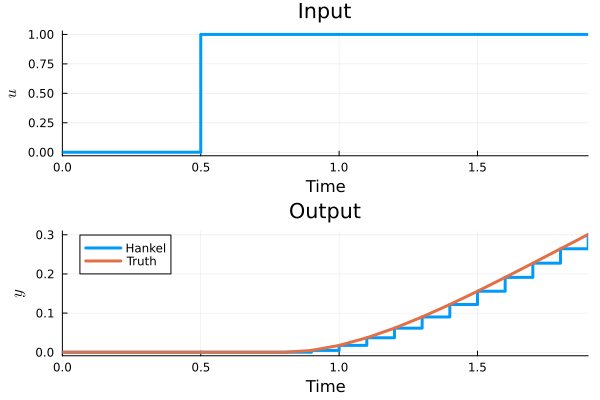

In [41]:
ū = [zeros(ν); ones(L-ν)]
y_init = zeros(ν)

ȳ = complete_trajectory(ū, y_init, H_u, H_y, H_y_nu)

## Get groundtruth
y, t, x, = lsim(P, ū')
y_true = vec(y)

plt = plot( 
    xaxis  = ("Time", ),
    xlims = (0, t[end]),
    layout = (2,1),
)
plot!(plt[1], t, ū, title = "Input", ylabel = L"u", linetype=:step, legend=false, lw=3)
plot!(plt[2], t, ȳ, title = "Output", ylabel = L"y", linetype=:step, label="Hankel", lw=3)
plot!(plt[2], t, y_true, label="Truth", legend=:topleft, lw=3)

# Closed-loop?

* So far we have computed the open-loop response with a vector of inputs.
* Now let's dynamically generate the output in closed-loop.

Notice that if the underlying system is proper (that is, $D = 0$), then we can extrapolate one step from a given trajectory:

* $\{ \bar{u}_t, \bar{y}_{t} \}_{t=0}^{\nu-1}$  is a trajectory if and only if there is $\alpha$ such that:
$$
\begin{bmatrix}
H_L(u)\\
H_{L}(y)
\end{bmatrix}
\alpha
= \begin{bmatrix}
\bar{u}\\
\bar{y}
\end{bmatrix}
$$
* Moreover, the full output is given by $\bar{y}_{0}^{L} = H_{L+1}(y) \alpha$ because $\bar{y}_{L}$ does not depend on any choice of $\bar{u}_{L}$ (which is to be determined in closed-loop).


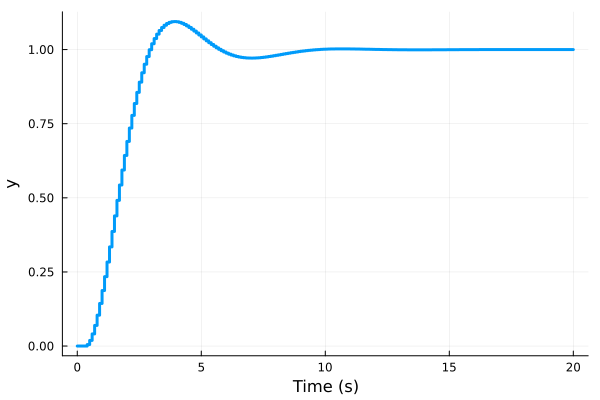

In [42]:
C = ss(c2d(pid(kp=1.7*0.63, ki=0.63), Ts))
CL = feedback(P*C)

plot(step(CL), lw=3)

In [43]:
steps = 100
r = ones(steps)
# r = sin.(1:steps)

Pss = ss(P)

y_true, t, x, = lsim(CL, r')
c_true, t, x, = lsim(C/(1 + C*P), r')

u = excite(2*ν)
y, _, x,  = lsim(P, u')
H_u = Hankel(u[1:end-1], ν)
H_y = Hankel(vec(y)[1:end-1], ν)
H_y_pred = Hankel(vec(y), ν+1)
# (C, steps, H_u, H_y, H_y_init; λ::Float64=0, r="ones", solver="back")
U, Y = closed_loop_trajectory(C, steps, H_u, H_y_pred, H_y, λ=0.0, r = "ones", solver="back")
;

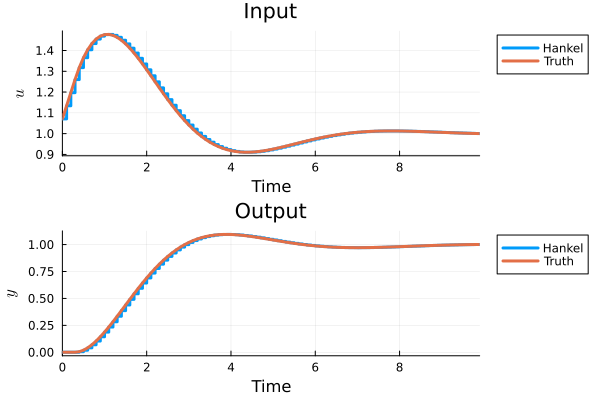

In [44]:
plt = plot( 
    xaxis  = ("Time", ),
    xlims = (0, t[end]),
    layout = (2,1),
)

plot!(plt[1], t, U, title = "Input", ylabel = L"u", label="Hankel", linetype=:step, lw=3)
plot!(plt[1], t, vec(c_true), title = "Input", ylabel = L"u", label="Truth", legend=:outertopright, lw=3)
plot!(plt[2], t, Y, title = "Output", ylabel = L"y", label="Hankel", linetype=:step, lw=3)
plot!(plt[2], t, vec(y_true), title = "Output", label="Truth", legend=:outertopright, lw=3)

# Noise?

* The fundamental lemma holds for deterministic LTI systems. **How can we deal with noisy data?**
* I'll show two approaches: regularization and smoothing

## Regularization

* The "standard" approach to dealing with noisy data is to solve the regularized least-squares problem:

$$
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\alpha = \text{argmin}_{\alpha} \norm{[H_{L}(u); H_{L}(y)] \alpha - [\bar{u}; \bar{y}]}^2 + \lambda \norm{\alpha}^2
$$

where $\lambda \geq 0$ is a tuning parameter.

* Other approaches such as maximum liklihood estimation, or low-rank approximations (PCA) are possible as well.

In [45]:
# complete_trajectory() : Add method to complete_trajectory with regularization

# Smoothing

> ⚠️ This is something I haven't seen done by people in this area, but seems to work well -- feedback appreciated!

* Idea: In the presence of noise, our 'ideal' Hankel matrix is:

$$
\newcommand{\EE}{\mathbb{E}}
H_{L}(y) =
\begin{bmatrix}
	\EE[y_{0}] & \EE[y_{1}] & \ldots & \EE[y_{N-L}] \\
	\EE[y_{1}] & \EE[y_{2}] & \ldots & \EE[y_{N-L+1}] \\
	\vdots & \vdots & \ddots & \vdots \\
	\EE[y_{L-1}] & \EE[y_{L}] & \ldots & \EE[y_{N-1}]
\end{bmatrix}
$$

* So, if we take our input sequence $\{ u_{t} \}_{t=0}^{N-1}$ and the underlying state sequence (we don't have the states, but they exist) $\{ x_{t} \}_{t=0}^{N-1}$ and define **locally averaged** values:
\begin{align}
\hat{u}_{t} &\leftarrow \frac{1}{K} \sum_{n = t-K+1}^{t} u_{n}\\
\hat{x}_{t} &\leftarrow \frac{1}{K} \sum_{n = t-K+1}^{t} x_{n}\\
\end{align}

* Then using **linearity** of the underlying system, these new states and inputs induce a **"fictitious" trajectory** whose outputs are approximated by:
$$
\hat{y}_{t} \leftarrow \frac{1}{K} \sum_{n = t-K+1}^{t} y_{n} + \omega_n,
$$
which has variance $\frac{\sigma^2}{K}$.

* **We then use $\{ \hat{u}_{t}, \hat{y}_t \}_{t=0}^{N-1} \approx \{ \hat{u}_{t}, \mathbb{E}[\hat{y}_t] \}_{t=0}^{N-1}$ to construct our Hankel matrices.**

In [46]:
# noisy_trajectory() : get noisy trajectory from noisy system P

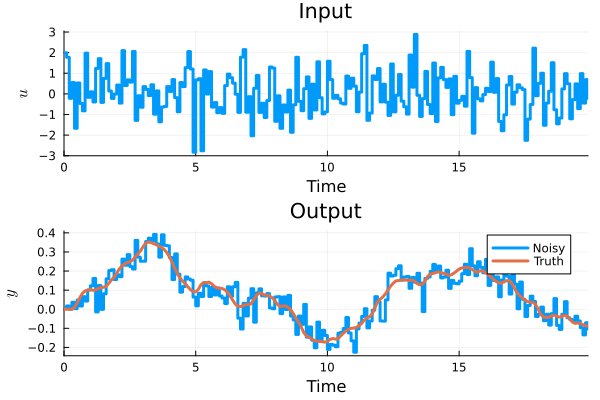

In [47]:
# Gather noisy "training" data
ν=8 # Interestingly, regularization is terrible when we set ν=n
u_train, y_train = noisy_trajectory(P, order=2ν, num_data=200, σ²=0.05)

y_true, t, x,  = lsim(P, u_train')

plt = plot( 
    xaxis  = ("Time", ),
    xlims = (0, t[end]),
    layout = (2,1),
)

plot!(plt[1], t, u_train, title = "Input", ylabel = L"u", legend=false, linetype=:step, lw=3)
plot!(plt[2], t, y_train, title = "Output", ylabel = L"y", label="Noisy", linetype=:step, lw=3)
plot!(plt[2], t, vec(y_true), title = "Output", label="Truth", legend=:topright, lw=3)

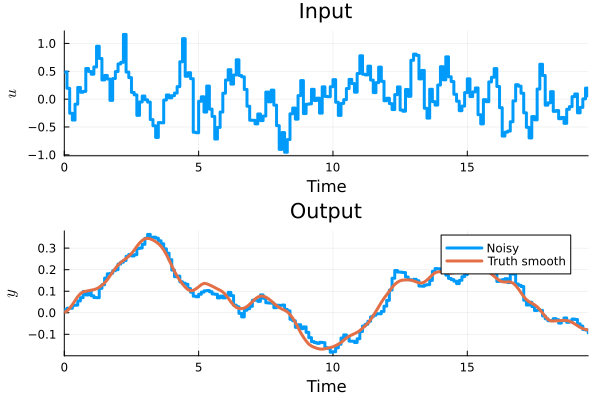

In [48]:
# Smooth our data
# u_train_smooth = imfilter(u_train', Kernel.gaussian(1))
# y_train_smooth = imfilter(y_train', Kernel.gaussian(1))
u_train_smooth = rollmean(u_train, 5)
y_train_smooth = rollmean(y_train, 5)

y_true_smooth, t, _, _  = lsim(P, u_train_smooth', x0=sum(x[:,1:5], dims=2)/5)

plt = plot( 
    xaxis  = ("Time", ),
    xlims = (0, t[end]),
    layout = (2,1),
)

plot!(plt[1], t, u_train_smooth, title = "Input", ylabel = L"u", legend=false, linetype=:step, lw=3)
plot!(plt[2], t, y_train_smooth, title = "Output", ylabel = L"y", label="Noisy", linetype=:step, lw=3)
plot!(plt[2], t, vec(y_true_smooth), title = "Output", label="Truth smooth", legend=:topright, lw=3)

In [49]:
steps = 100
r = ones(steps)
# r = sin.(0.5*(1:steps))

y_true, t, x, = lsim(CL, r')
c_true, t, x, = lsim(C/(1 + C*P), r')

H_u = Hankel(vec(u_train)[1:end-1], ν)
H_y = Hankel(vec(y_train)[1:end-1], ν)
H_y_pred = Hankel(vec(y_train), ν+1)

H_u_smooth = Hankel(vec(u_train_smooth)[1:end-1], ν)
H_y_smooth = Hankel(vec(y_train_smooth)[1:end-1], ν)
H_y_pred_smooth = Hankel(vec(y_train_smooth), ν+1)

U_reg, Y_reg = closed_loop_trajectory(C, steps, H_u, H_y_pred, H_y, λ=0.01, r="ones")
U_smooth, Y_smooth = closed_loop_trajectory(C, steps, H_u_smooth, H_y_pred_smooth, H_y_smooth, λ=0.0, r="ones")
;

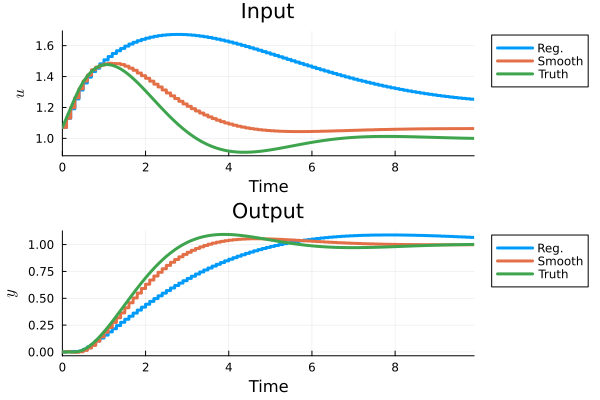

In [50]:
plt = plot( 
    xaxis  = ("Time", ),
    xlims = (0, t[end]),
    layout = (2,1),
)

plot!(plt[1], t, U_reg, title = "Input", ylabel = L"u", label="Reg.", linetype=:step, lw=3)
plot!(plt[1], t, U_smooth, title = "Input", ylabel = L"u", label="Smooth", linetype=:step, lw=3)
plot!(plt[1], t, vec(c_true), title = "Input", ylabel = L"u", label="Truth", legend=:outertopright, lw=3)

plot!(plt[2], t, Y_reg, title = "Output", ylabel = L"y", label="Reg.", linetype=:step, lw=3)
plot!(plt[2], t, Y_smooth, title = "Output", ylabel = L"y", label="Smooth", linetype=:step, lw=3)
plot!(plt[2], t, vec(y_true), title = "Output", label="Truth", legend=:outertopright, lw=3)

Some empirical observations:

* Regularization is **sensitive** to our estimate of $\nu$, as well as the tuning parameter $\lambda$.
* Smoothing appears to be **robust** to high levels of noise and **insensitive** to our estimate of $\nu$.
* One benefit of smoothing is that the averaging parameter $K$ is more interpretible (and coarse in nature) than $\lambda$.
* Smoothing explicitly takes advantage of the **LTI assumption**, however, more analysis is needed.

# Conclusion

* Behavioral systems theory gives an **equivalent characterization** of LTI systems to that of state-space models.
* One trajectory of data is needed and state/parameter estimation is not needed.

## Not emphasized here

* Behavioral systems is actually an independent, **"set theoretic"** framework without model representations (state space, transfer functions...).
* For example, one can define "controllability" and "observability" based on trajectories, not models.

## Ongoing and future directions

* Predictive control
* Extensions to nonlinear systems
* Effectively dealing with stochasticity
* Really any area with "nuisance" model identification

# References

1. Berberich J, Allgöwer F. A trajectory-based framework for data-driven system analysis and control. In2020 European Control Conference (ECC) 2020 May 12 (pp. 1365-1370). IEEE.
2. Willems JC, Rapisarda P, Markovsky I, De Moor BL. A note on persistency of excitation. Systems & Control Letters. 2005 Apr 1;54(4):325-9.
3. Markovsky I, Dörfler F. Behavioral systems theory in data-driven analysis, signal processing, and control. Annual Reviews in Control. 2021 Jan 1;52:42-64.

This presentation was created using [Jupyter](https://jupyter.org), [IJulia.jl](https://github.com/JuliaLang/IJulia.jl) (notebook), and [RISE](https://rise.readthedocs.io/en/stable/) (interactive slides).

## Continued...

In [51]:
# excite() : add a 'minimal' excitation method

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


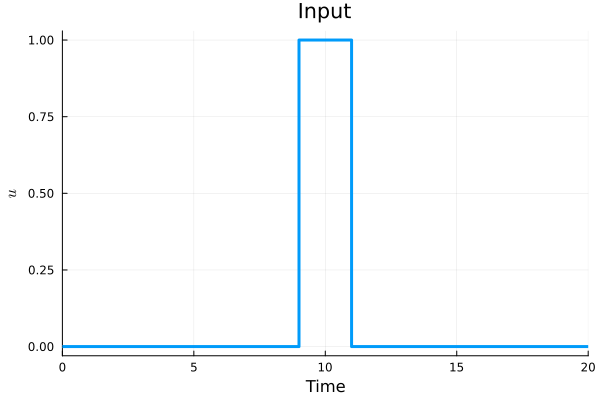

In [52]:
let
    u_example = excite(10, 2)
    println(u_example)
    plt = plot( 
        xaxis  = ("Time", ),
        xlims = (0, length(u_example)-1)
    )

    plot!(0:length(u_example)-1, u_example, title = "Input", ylabel = L"u", legend=false, linetype=:step, lw=3)
end

In [53]:
# get_rand_trajectory() : get random trajectory under Hankel matrix model

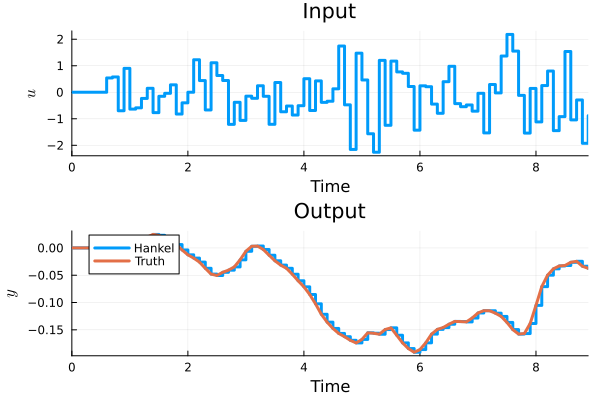

In [54]:
ν = 5+1
L = 20

# Probe the 'true' system
u = excite(ν+L)
y, t, x,  = lsim(P, u')
H_u = Hankel(u, L)
H_y = Hankel(vec(y), L)
H_y_nu = Hankel(vec(y)[1:length(y) - L + ν], ν)

ū, ȳ = get_rand_trajectory(H_u, H_y, H_y_nu, 100)

## Get groundtruth
y, t, x, = lsim(P, ū')
y_true = vec(y)

plt = plot( 
    xaxis  = ("Time", ),
    xlims = (0, t[end]),
    layout = (2,1),
)
plot!(plt[1], t, ū, title = "Input", ylabel = L"u", linetype=:step, legend=false, lw=3)
plot!(plt[2], t, ȳ, title = "Output", ylabel = L"y", linetype=:step, label="Hankel", lw=3)
plot!(plt[2], t, y_true, label="Truth", legend=:topleft, lw=3)


In [55]:
# get_rand_trajectory() : new method, computes random trajectory using noisy i/o data

In [56]:
# Expensive cell to run!

# Set parameters for heatmap experiment
L = 6

σ² = 0:0.01:0.08
K = 1:9
λ = 0:0.01:0.08
rollouts = 1

u_excite = excite(2L+maximum(K), num_data = 150)
y, t, x,  = lsim(P, u_excite')

err_K = []
err_reg = []
for var in σ²
    for k in K
        AE = 0.0
        for i in 1:rollouts
            _, _, _, _, error = get_rand_trajectory(u_excite, y, L, 100, P, var, K=k, λ=0.0)
            AE += error
        end
        append!(err_K, AE/rollouts)
    end
end

for var in σ²
    for reg in λ
        AE = 0.0
        for i in 1:rollouts   
            _, _, _, _, error = get_rand_trajectory(u_excite, y, L, 100, P, var, K=1, λ=reg)
            AE += error
        end
        append!(err_reg, AE/rollouts)
    end
end


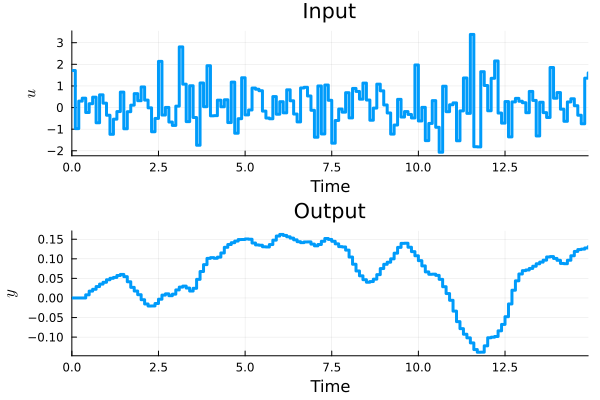

In [58]:
# Data given for the heatmap experiments
plt = plot( 
    xaxis  = ("Time", ),
    xlims = (0, t[end]),
    layout = (2,1),
)
plot!(plt[1], t, u_excite, title = "Input", ylabel = L"u", linetype=:step, legend=false, lw=3)
plot!(plt[2], t, vec(y), title = "Output", ylabel = L"y", linetype=:step, legend=false, lw=3)

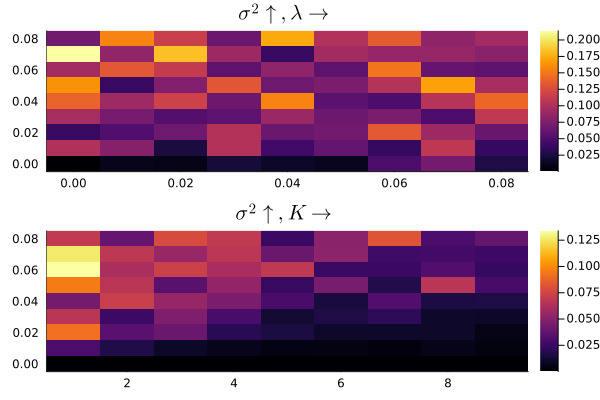

In [59]:

# using PlotlyJS

# plot(
#     heatmap(
#         x=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"],
#         y=["Morning", "Afternoon", "Evening"],
#         z=[1 25 30 50 1; 20 1 60 80 30; 30 60 1 5 20]',
#     ),
# )
# heatmap(K,
#     σ², reshape(err_K, (length(K), length(σ²))),
#     xlabel="x values", ylabel="y values",
#     title="My title")


# A = randn(3,4)
# println(A)
# println(reverse(A, dims=1))

# plot(heatmap(reverse(A, dims=1)), colorscale="Viridis")

# plot!(plt[1], heatmap(reshape(err_K, (length(K), length(σ²)))))
# println(reshape(err_reg, (length(λ), length(σ²))))
# heatmap(reverse(reshape(err_reg, (length(λ), length(σ²)))),dims=1)
# plot(heatmap(z=reshape(err_reg, (length(λ), length(σ²))), x = λ, y = σ² ))

plt = plot( 
    xaxis=(L"\lambda", ),
    layout = (2,1),
)
# plot!(plt[1], xaxis  = (L"\lambda", ))

hm_reg = heatmap(λ, σ², reshape(err_reg, (length(σ²), length(λ)))', title=L"\sigma^2 \uparrow, \lambda \rightarrow")



# println(reshape(err_K, (length(σ²), length(K)))')

hm_K = heatmap(K, σ², reshape(err_K, (length(σ²), length(K)))', title=L"\sigma^2 \uparrow, K \rightarrow")

plot([hm_reg, hm_K]..., layout = (2,1), grid=false)

# plot(
#     heatmap(
#         x=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"],
#         y=["Morning", "Afternoon", "Evening"],
#         z=[1 25 30 50 1; 20 1 60 80 30; 30 60 1 5 20]',
#     ),
#     Layout(xaxis_side="top")
# )


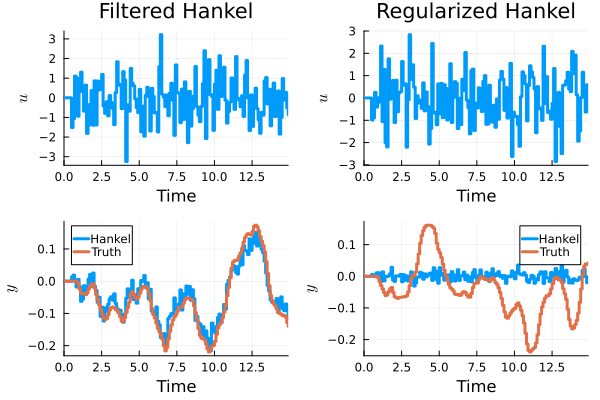

In [60]:
plt = plot( 
    xaxis  = ("Time", ),
    xlims = (0, t[end]),
    layout = (2,2),
)
variance = 0.04
ū_filt, ȳ_filt, y_true_filt, t_filt,_ = get_rand_trajectory(u_excite, y, L, 150, P, variance, K=5, λ=0.0)
ū_reg, ȳ_reg, y_true_reg, t_reg,_ = get_rand_trajectory(u_excite, y, L, 150, P, variance, K=1, λ=0.1)

plot!(plt[1], t_filt, ū_filt, title = "Filtered Hankel", ylabel = L"u", linetype=:step, label="Input", legend=false, lw=3)
plot!(plt[2], t_filt, ū_reg, title = "Regularized Hankel", ylabel = L"u", linetype=:step, label="Input", legend=false, lw=3)

plot!(plt[3], t_filt, ȳ_filt, ylabel = L"y", linetype=:step, label="Hankel", lw=3)
plot!(plt[3], t_filt, y_true_filt, ylabel = L"y", linetype=:step, label="Truth", lw=3)

plot!(plt[4], t_reg, ȳ_reg, ylabel = L"y", linetype=:step, label="Hankel", lw=3)
plot!(plt[4], t_reg, y_true_reg, ylabel = L"y", linetype=:step, label="Truth", lw=3)
# plot!(plt[1], 0:length(y_true_filt), y_true_filt)